In [30]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from glob import glob
import cv2
import torch

In [100]:
def sample_pdf_2(bins, weights, num_samples, det="uniform"):
    r"""sample_pdf function from another concurrent pytorch implementation
    by yenchenlin (https://github.com/yenchenlin/nerf-pytorch).
    """
    
    weights = weights + 1e-5
    pdf = weights / torch.sum(weights, dim=-1, keepdim=True)
    cdf = torch.cumsum(pdf, dim=-1)
    cdf = torch.cat(
        [torch.zeros_like(cdf[..., :1]), cdf], dim=-1
    )  # (batchsize, len(bins))

    # sampling
    if det == "chebyshev":
        k = torch.arange(1, num_samples+1, dtype=weights.dtype, device=weights.device)
        u = ((torch.cos((2*k - 1)*3.1415926535/(2*num_samples)) + 1)/2).sort()[0]
        u = u.expand(list(cdf.shape[:-1]) + [num_samples])
    if det == "uniform":
        u = torch.linspace(
            0.0, 1.0, steps=num_samples, dtype=weights.dtype, device=weights.device
        )
        u = u.expand(list(cdf.shape[:-1]) + [num_samples])
    elif det == "random":
        u = torch.rand(
            list(cdf.shape[:-1]) + [num_samples],
            dtype=weights.dtype,
            device=weights.device,
        )

    # Invert CDF
    u = u.contiguous()
    cdf = cdf.contiguous()
    inds = torch.searchsorted(cdf.detach(), u, right=True)
    below = torch.max(torch.zeros_like(inds - 1), inds - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack((below, above), dim=-1)  # (batchsize, num_samples, 2)

    matched_shape = (inds_g.shape[0], inds_g.shape[1], cdf.shape[-1])
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples, cdf

In [121]:
z_vals_fine_64 = torch.load("rays/64/z_vals_fine/1.pt", map_location="cpu").detach()
weights_64 = torch.load("rays/64/weights/1.pt", map_location="cpu").detach()
z_vals_mid_64 = torch.load("rays/64/z_vals_mid/1.pt", map_location="cpu").detach()

In [175]:
samples_64, cdf_64 = sample_pdf_2(z_vals_mid_64, weights_64[..., 1:-1], 128, "chebyshev")

In [176]:
# ind = torch.randperm(len(samples_64))
# samples_64 = samples_64[ind]

In [187]:
uniform = torch.linspace(2,6,128)

In [197]:
a = 0.9*samples_64[0] + 0.1*uniform

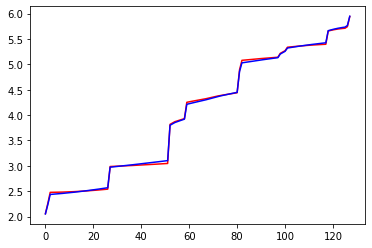

In [198]:
plt.plot(samples_64[0], alpha=1, c="red")
plt.plot(a, alpha=1, c="blue")


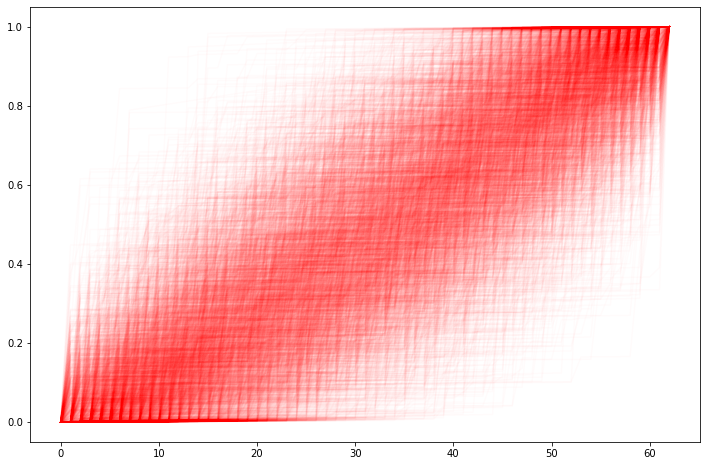

In [127]:
plt.figure(figsize=(12,8))
for i in range(4000):
    plt.plot(cdf_64[i], alpha=0.015, c="red")
# plt.plot(torch.linspace(2,6,len(samples_64[i])), alpha=1, c="blue")
plt.show()

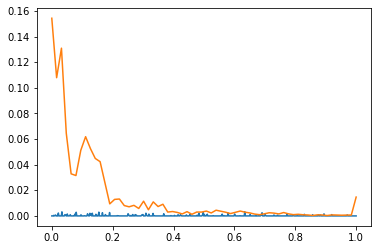

In [29]:
plt.plot(np.linspace(0,1,len(weights_512[0])), weights_512[0])
plt.plot(np.linspace(0,1,len(weights_64[0])), weights_64[0])